In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import nltk
from nltk.corpus import stopwords
import re
import pickle
%matplotlib inline
plt.style.use('ggplot')

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')          
stopWords = list(stopwords.words('english'))   

def is_stock_up(row):
    return True if row[1] < row[4] else False


def tokenize_paragraph(paragraph):
    raw_sentences = tokenizer.tokenize(paragraph)
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_wordlist(raw_sentence.lower()))
    return sentences
            
        
def remove_stopwords(sentences):
    sent_remove_stopwords = []
    for sent in sentences:
        append_sent = []
        for word in sent:
            if word not in stopWords:
                append_sent.append(word)
        sent_remove_stopwords.append(append_sent)
    return sent_remove_stopwords
        
            
def clean_text(paragraph):
    paragraph = paragraph.replace(u'\xa0', u' ')
    sentences = tokenize_paragraph(paragraph)
    sent_remove_stopwords = remove_stopwords(sentences)
    words = []
    for sent in sent_remove_stopwords:
        for word in sent:
            words.append(word)
    return words

#check gensim
def get_paragraph_vectors(tokens): 
    num_tokens = len(tokens)
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]
    global doc2vec
    doc2vec = Doc2Vec(documents, vector_size=100, min_count=3, workers=12, epochs=25)       
    return [doc2vec.dv[i] for i in range(num_tokens)]

#check gensim
def get_infered_vectors(tokens):
    return model.infer_vector(tokens)
       
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

def reduce_dimensions(vectors):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # reduce using t-SNE
    print('transforming to vectors...')
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    print('applying tsne...')
    vectors = tsne.fit_transform(vectors)
    print('appending to list...')
    X = [v[0] for v in vectors]
    y = [v[1] for v in vectors]
    return X, y

def get_numpy_array(pandas_series, num_features=300):
    zeroes = np.empty((len(pandas_series),num_features))
    i = 0
    for vectors in pandas_series:
        zeroes[i] = np.array(vectors)
        i+=1
    return zeroes

def get_autoencoder_result(numpy_array):
    encoded_text = encoder.predict(numpy_array)
    return decoder.predict(encoded_text)

def get_vector_difference(initial_vector, decoded_vector):
    return np.absolute(initial_vector.sum() - decoded_vector.sum())

#check gensim
def get_word_vectors(model):
    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.key_to_index:
        vectors.append(model.wv[word])
        labels.append(word)
    return vectors, labels

In [9]:
df = pd.read_csv('cleaned_wsb.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310648 entries, 0 to 1310647
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Unnamed: 0    1310648 non-null  int64 
 1   body          1310648 non-null  object
 2   created_utc   1310648 non-null  object
 3   is_submitter  1310648 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 31.2+ MB


In [11]:
df = df.drop('Unnamed: 0',axis=1)
df.head()

,body,created_utc,is_submitter
0,1:11am here no fucking shot I’m sleeping anyti...,2021-01-11 08:11:51,False
1,"Buy calls at open, everyone person alive is go...",2021-01-11 08:11:49,False
2,Twitter going down,2021-01-11 08:11:48,False
3,Kinda sucks though. Missing out on the opportu...,2021-01-11 08:11:46,False
4,U think first time investors won’t panic when ...,2021-01-11 08:11:43,False


In [19]:
df.sample(frac=0.2,random_state=42).to_csv('cleaned_wsb_sample.csv')

In [5]:
df.created_utc = pd.DatetimeIndex(data=df.created_utc,tz='Etc/Universal')

In [ ]:
df.head()

In [ ]:
df.sort_values('created_utc', inplace=True)
df.head()

In [ ]:
df.info()

In [ ]:
df.created_utc = df.created_utc.apply(lambda timestamp : timestamp.tz_convert('US/Eastern'))

In [ ]:
df.head()

In [ ]:
stocks = ['GME.csv','BB.csv','AMC.csv','NOK.csv','PLTR.csv','TSLA.csv']
df_stocks = []
for stock in stocks:
    df_stocks.append(pd.read_csv(stock))

In [ ]:
filtered_stocks = []
for frame in df_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date)
    filtered_stocks.append(frame[frame.Date >= datetime(2021, 1, 1)])
    

In [ ]:
df_stocks = []
for frame in filtered_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date,tz='Etc/Universal')
    frame.Date = frame.Date.apply(lambda timestamp : timestamp.tz_convert('US/Eastern'))
    df_stocks.append(frame)

In [ ]:
for frame in df_stocks:
    frame['is_stock_up'] = frame.apply(is_stock_up,axis=1)

In [ ]:
df_stocks[1].head()

In [6]:
df['tokens'] = df.body.apply(clean_text)
df.head()

,body,created_utc,is_submitter,tokens
0,1:11am here no fucking shot I’m sleeping anyti...,2021-01-11 08:11:51+00:00,False,"[fucking, shot, sleeping, anytime, till]"
1,"Buy calls at open, everyone person alive is go...",2021-01-11 08:11:49+00:00,False,"[buy, calls, open, everyone, person, alive, go..."
2,Twitter going down,2021-01-11 08:11:48+00:00,False,"[twitter, going]"
3,Kinda sucks though. Missing out on the opportu...,2021-01-11 08:11:46+00:00,False,"[kinda, sucks, though, missing, opportunity, b..."
4,U think first time investors won’t panic when ...,2021-01-11 08:11:43+00:00,False,"[u, think, first, time, investors, panic, shit..."


In [7]:
df=df.drop(['body','created_utc','is_submitter'],axis=1)
df.head()

,tokens
0,"[fucking, shot, sleeping, anytime, till]"
1,"[buy, calls, open, everyone, person, alive, go..."
2,"[twitter, going]"
3,"[kinda, sucks, though, missing, opportunity, b..."
4,"[u, think, first, time, investors, panic, shit..."


In [13]:
vectors = get_paragraph_vectors(df['tokens'])
df['vectors'] = vectors

In [14]:
X = np.array(vectors).reshape(len(vectors),len(vectors[0]))
X.shape

(1310648, 100)

In [15]:
neighbors = NearestNeighbors(n_neighbors=20, n_jobs=10)
print('Fitting...')
neighbors_fit = neighbors.fit(X)
print('Finding K Neighbors...')
distances, indices = neighbors_fit.kneighbors(X)
print('Sorting...')
distances = np.sort(distances, axis=0)
print('Getting 2nd column...')
distances = distances[:,1]

Fitting...
Finding K Neighbors...
Sorting...
Getting 2nd column...


In [17]:
pd.DataFrame({'Distances':distances}).to_csv('Distances.csv')

Text(0.5, 0, 'Number of samples')

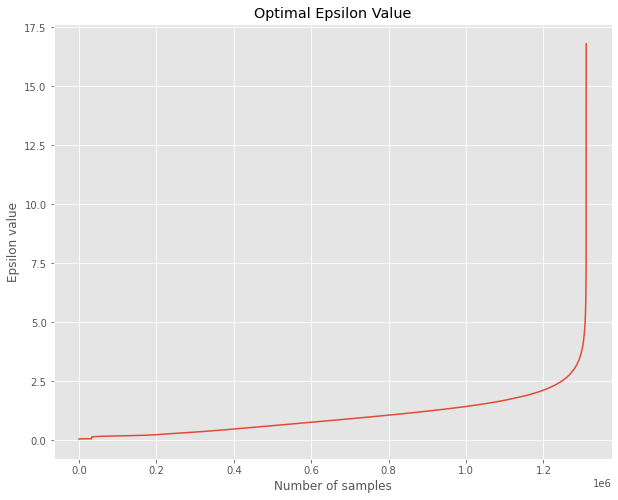

In [24]:
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('Optimal Epsilon Value')
plt.ylabel('Epsilon value')
plt.xlabel('Number of samples')


In [4]:
dbscan = DBSCAN(eps=3,min_samples=20,n_jobs=-1)

In [3]:
doc2vec = pickle.load(open('doc2vec.sav', 'rb'))

In [5]:
vectors = [doc2vec.dv[i] for i in range(1310648)]

In [6]:
vectors = np.array(vectors).reshape(len(vectors),len(vectors[0]))

In [7]:
vectors.shape

(1310648, 100)

In [8]:
dbscan.fit(vectors)

MemoryError: Unable to allocate 42.5 MiB for an array with shape (102, 109221) and data type float32